# Predição da Série Temporal do  índice do Ibovespa
<img src="https://cointimes.com.br/wp-content/uploads/2019/01/indice-ibovespa-1024x450.jpg">

### Introdução
A presente análise busca fazer uma predição dos futuros valores de fechamento do índice do Ibovespa.
Os dados serão coletados através da API do Yahoo Finance e a predição será feita através de um modelo de redes neurais (LSTM Networks).
Tentativas foram feitas utilizando outros algoritmos de séries temporais como ARIMA, SARIMA e a bibliote Prophet. Entretando, nenhuma das citadas alcançou uma performance adequada quando o modelo de LSTM. Os outros modelos podem ser visualizados no link: https://github.com/GusdPaula/postgraduation_fiap/blob/7775df33d5e067c101ccc09af1b5f49910b72b05/ibov_prediction/ibov_draft.ipynb

O Ibovespa é o índice que, mede o desempenho das ações de empresas com grande volume de negociação na Bolsa de Valores oficial do Brasil.

### Sobre os dados

Como já mencionado, os dados serão extraídos através da API do Yahoo Finance.
A estrutura do dataset extraído se encontra com as segintes features:
<li><b>Date</b> - A data que do preço no formato "'%Y-%m-%d %H:%M:%S.%f'", começando de janeiro de 2016 até o mês presente (Setembro no caso, pois foi o mês onde a análise foi feita. Será o nosso index.</li>
<li><b>Open</b> - O preço de abertura do índice no mês. Não iremos utilizar.</li>
<li><b>High</b> - O preço máximo do índice no mês. Não iremos utilizar.</li>
<li><b>Low</b> - O preço mínimo do índice no mês. Não iremos utilizar.</li>
<li><b>Close</b> - O preço de fechamento do índice no mês. Este será o nosso Y para predição dos valores.</li>
<li><b>Volume</b> - Volume de movimentações índice no mês. Não iremos utilizar.</li>
<li><b>Dividends</b> - Dividendos pados do índice no mês. Não iremos utilizar.</li>
<li><b>Splits</b> - Divisão de ações do índice no mês. Não iremos utilizar.</li>

### O Modelo

O modelo usado será o de redes neurais Long Short Term Memory networks ou “LSTMs”. Este tipo de redes neurais se trata de uma RNN (Recurent Neural Network), capaz de aprender dependências no longo prazo. Elas funcionam muito bem para uma grande variedade de problemas.
LSTMs são ótimas para evitar o problema de dependência no longo prazo. Lembrando informações por longos periodos é praticamente seu comportamento padrão.
Na presente análise LSTMs irão analisar como o preço se comporta através do tempo e predizer valores futuros.

Para mais informações sobre as redes neurais utilizadas acesse o link abaixo:<br>
<a>https://colah.github.io/posts/2015-08-Understanding-LSTMs/</a>

E sem mais demora, vamos para a nossa análise<br>
<img src="https://github.com/GusdPaula/postgraduation_fiap/blob/main/ibov_prediction/chapolin.gif?raw=true">

### Importando bibliotecas que serão utilizadas

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
from math import floor,ceil,sqrt
import warnings
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

warnings.filterwarnings("ignore")

### Importando dados e primeiras análises

A seguir você vera algumas amostragens da base de dados do Ibovespa. Primeiro, a base de dados será importada e as 5 primeiras linhas serão mostradas para identificação de sua estrutura.

In [2]:
ibov_data = yf.Ticker("BOVV11.SA")
ibov_df = pd.DataFrame(ibov_data.history(period="max"))

# Ajustando o index para não mostrar horas
ibov_df['Date'] = pd.to_datetime(ibov_df.index, format='%Y-%m-%d').date
ibov_df.index = ibov_df['Date']
ibov_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2016-08-01,57.250000,57.250000,57.250000,57.250000,0,0.0,0.0,2016-08-01
2016-08-02,56.650002,56.650002,56.650002,56.650002,0,0.0,0.0,2016-08-02
2016-08-04,57.590000,57.590000,57.590000,57.590000,1000,0.0,0.0,2016-08-04
2016-08-05,57.500000,57.660000,57.500000,57.660000,1060,0.0,0.0,2016-08-05
2016-08-09,57.680000,57.680000,57.680000,57.680000,1000,0.0,0.0,2016-08-09


Com a estrutura plotada, pode-se notar, basicamente, as colunas já descritas na introdução.

Agora que se conhece a estrutura, é importante reconhecer os tipos da coluna, ou formato (texto, número, etc.), e se existem valores nulos, pois valores nulos podem impactar negativamente a análise.

In [3]:
# Procurando valores nulos
ibov_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1957 entries, 2016-08-01 to 2024-09-11
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1957 non-null   float64
 1   High          1957 non-null   float64
 2   Low           1957 non-null   float64
 3   Close         1957 non-null   float64
 4   Volume        1957 non-null   int64  
 5   Dividends     1957 non-null   float64
 6   Stock Splits  1957 non-null   float64
 7   Date          1957 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 137.6+ KB


Aqui se percebe novamente as colunas descritas na introdução e seu tipo. Todas as colunas, exceto Date - que é uma data, são numéricas e não temos nenhum valor nulo.

Também é importante analisar as primeras métricas estatísticas para se ter uma ideai da distribuição.

In [4]:
# Primeiros dados estatísticos
ibov_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1957.000000,1957.000000,1957.000000,1957.000000,1.957000e+03,1957.0,1957.0
mean,100.809545,101.538758,100.002095,100.773040,1.412457e+06,0.0,0.0
std,21.045959,21.244828,20.891530,21.078143,1.498919e+06,0.0,0.0
min,56.650002,56.650002,56.650002,56.650002,0.000000e+00,0.0,0.0
25%,84.199997,84.559998,83.250000,83.940002,2.765000e+05,0.0,0.0
50%,104.879997,105.650002,103.980003,104.820000,1.123722e+06,0.0,0.0
75%,117.029999,117.919998,116.139999,117.139999,1.964237e+06,0.0,0.0
max,139.990005,140.259995,139.399994,140.130005,1.820953e+07,0.0,0.0


Das primeiras medidas pode-se tomar certas afirmações:
1. Dividends e Stock Splits estão vazias para todas as linhas.
2. Os valores mínimos e máximos para Open, High, Low, Close e Volume.
3. A média e desvio padrão para Open, High, Low, Close e Volume.
4. E por último sua distribuição nos quartis (25, 50 e 75).

Outra ação necessária é plotar gráficos para entender visualmente o comportamentos dos dados.

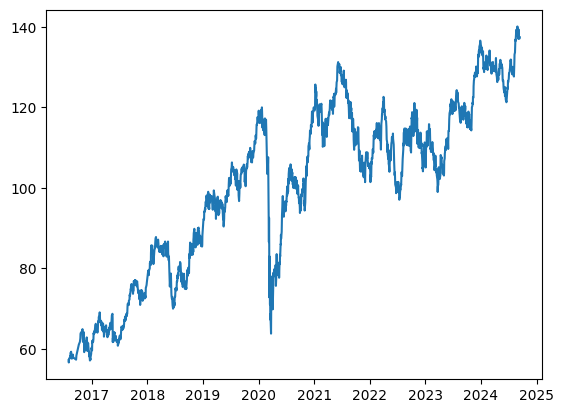

In [5]:
# Plotando o comportamento do preço
plt.plot(ibov_df.index, ibov_df['Close'])
plt.show()

Aqui pode-se notar uma clara tendência de alta ao longo dos anos para o índice, com várias oscilações que não alteraram sua trajetória.

Os gráficos também irão ajudara seguir a identificar algumas métricas das séries temporais.

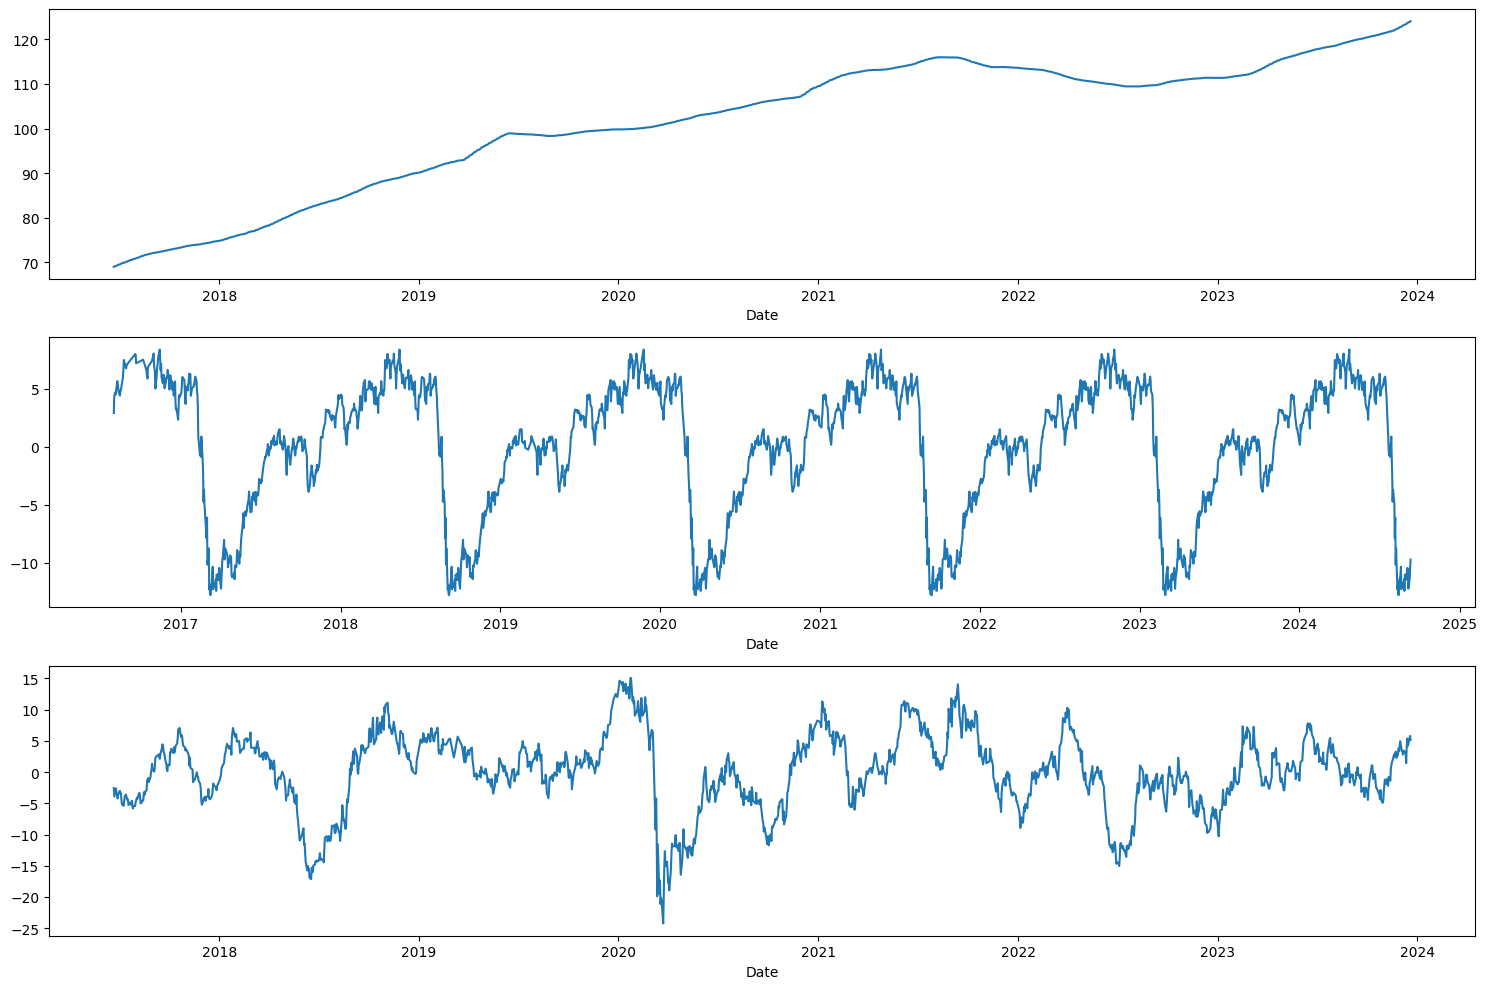

In [6]:
# Analizando métricas das séries temporais
ibov_df_close = ibov_df['Close']
results = seasonal_decompose(x=ibov_df_close, period=365)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (15,10))
results.trend.plot(ax=ax1)
results.seasonal.plot(ax=ax2)
results.resid.plot(ax=ax3)

plt.tight_layout()

Pode-se notar no primeiro gráfico a tendência bem clara de subida. No segunda, sua sazonalidade aparente e no terceiro como seu ruído se comporta (aparentemente sem tendência)

### Criando Modelo

O modelo escolhido para predição dos valores da série é o LSTM (Long Short-Term Memory), um modelo de RNN (Recurent Neural Network) que possui a capacidade de memorizar informações relevantes no longo prazo. Ele funciona com três portas: a de entrada, que permite a entrada de informações; a de esquecimento, que permite que informações sejam descartadas; e o de saída que filtra e controla as informações relevantes.

Para mais informações sobre o modelo acesse o link abaixo:<br>
https://awari.com.br/lstm-em-deep-learning-modelos-de-memoria-de-longo-prazo/#:~:text=O%20LSTM%20%28Long%20Short-Term%20Memory%29%20%C3%A9%20um%20tipo,aprenda%20e%20memorize%20informa%C3%A7%C3%B5es%20relevantes%20de%20longo%20prazo.

In [13]:
### TODO: Explicar melhor o modelo e fazer backtest https://subpath.medium.com/backtesting-time-series-models-weekend-of-a-data-scientist-92079cc2c540


def lstm_prediction(df):
    '''
        Esta função irá fazer o papel de predizer os valores da série temporal utilizando o LSTM.

    '''

    # Pegando o número de linhas para fazer o split do DataFrame
    shape=df.shape[0]

    # Selecionanco apenas a coluna relevante, neste caso, Close
    df_new=df[['Close']]

    # Transformando a coluna em uma série
    dataset = df_new.values

    # Fazendo o split do DataFrame para treino e test
    train=df_new[:ceil(shape*0.75)]
    valid=df_new[ceil(shape*0.75):]
    
    print('-----------------------------------------------------------------------------')
    print('---------------------PREDIÇÃO DO PREÇO DO ÍNDICE IBOVESPA--------------------')
    print('-----------------------------------------------------------------------------')

    # Normalizando os dados de treino
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train)

    # Fazendo mais um split, apendas dos dados de treino, pois 40 dias destes dados irão ser usados apenas no test e não no treino
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])

    # Transformando as listas em um array numpy
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Transformando linhas em colunas para utilizar no modelo
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    # Criando um modelo Sequencial que permite criar o modelo camada por camada, porém não permite criar modelo
    # que compartilhas camadas ou aceita múltiplos inputs e outputs
    model = Sequential()

    # Adicionando a primeira LSTM layer
    # 50 units é o número de unidade de memória para a camada
    # return_sequences como True irá permitir que o modelo veja o valor escondido que irá ser passado para a próxima etapa
    # input_shape é o tamanho da série
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))

    # Adicionando a segunda LSTM layer 
    model.add(LSTM(units=50))

    # Adicionando uma Dense layer para captação de tendências e ajudar no processamento
    model.add(Dense(1))

    # Compilando o modelo
    # mean_squared_error penaliza erros maiores de forma mais severa, devido ao seu cálculo que envolve a elevação ao quadrado das diferenças
    # Adam é um algoritmo de nível de aprendizado adaptável.
    # Isso significa que ele ajusta dinamicamente o nível de aprendizado para cada parâmetro individual dentro de um modelo
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Treinando o modelo
    # epochs é 1, pois 1 epoch significa que cadas amostra nos dados de treino teve a portunidade de atualizar os parâmetros internos do modelo
    # batch_size é 1, pois 1 amostra para trabalhar antes de atualizar os parâmetros internos do modelo
    # verbose é como o processo de treino, progress bar, irá ser mostrado.
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    # Obtendo os valores de test, apenas os últimos 40 dias.
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    # Transformando os valores de teste em lista
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])

    # Transformando as listas em um array numpy
    X_test = np.array(X_test)

    # Transformando linhas em colunas para utilizar no modelo
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    # Fazendo a predição
    closing_price = model.predict(X_test)

    # Voltando oo formato original
    closing_price = scaler.inverse_transform(closing_price)

    # Obtendo a métrica RMSE
    # O RMSE, ou Root Mean Square Error, é uma medida da diferença entre os valores previstos por um modelo e os valores reais observados. 
    # Em outras palavras, ele quantifica o erro médio das previsões do modelo em relação aos dados reais.
    # Quanto menor o valor do RMSE, mais preciso é o modelo em suas previsões.
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE:',rms)

    # Obtendo o Erro quadrado
    # A métrica R², também conhecida como R-dois ou coeficiente de determinação,
    # representa o percentual da variância dos dados que é explicado pelo modelo.
    # Os resultados variam de 0 a 1, geralmente também são expressos em termos percentuais, ou seja, variando entre 0% e 100%.
    # Quanto maior é o valor de R², mais explicativo é o modelo em relação aos dados previstos
    valid['Predictions'] = closing_price
    print('Erro quadrado:', r2_score(valid['Close'], valid['Predictions']))

    # Obtendo WMAPE
    # O WMAPE (Weighted Mean Absolute Percentage Error) é uma das métricas mais utilizadas para medir a precisão das previsões de demanda. 
    # É uma variação do MAPE (Mean Absolute Percentage Error), que calcula a média dos erros percentuais 
    # absolutos entre as previsões e os valores reais. No entanto, o WMAPE atribui pesos diferentes aos erros em função da 
    # importância relativa de cada período de tempo.
    def wmape(y_true, y_pred):
      return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

    print('WMAPE:', wmape(valid['Close'], valid['Predictions']))
    
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    # Plotando os valores reais e previstos
    fig = plt.figure(figsize=(20, 10))
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Data',size=20)
    plt.ylabel('Preço',size=20)
    plt.title('PREDIÇÃO DO PREÇO DO ÍNDICE IBOVESPA',size=20)
    plt.legend(['Dados de Treino','Dados Reais','Dados Preditos'])

-----------------------------------------------------------------------------
---------------------PREDIÇÃO DO PREÇO DO ÍNDICE IBOVESPA--------------------
-----------------------------------------------------------------------------
1428/1428 - 44s - 31ms/step - loss: 0.0038
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
RMSE: 2.4125882127497102
Erro quadrado: 0.9392674409089014
WAPE: 0.01618293063199531
-----------------------------------------------------------
-----------------------------------------------------------


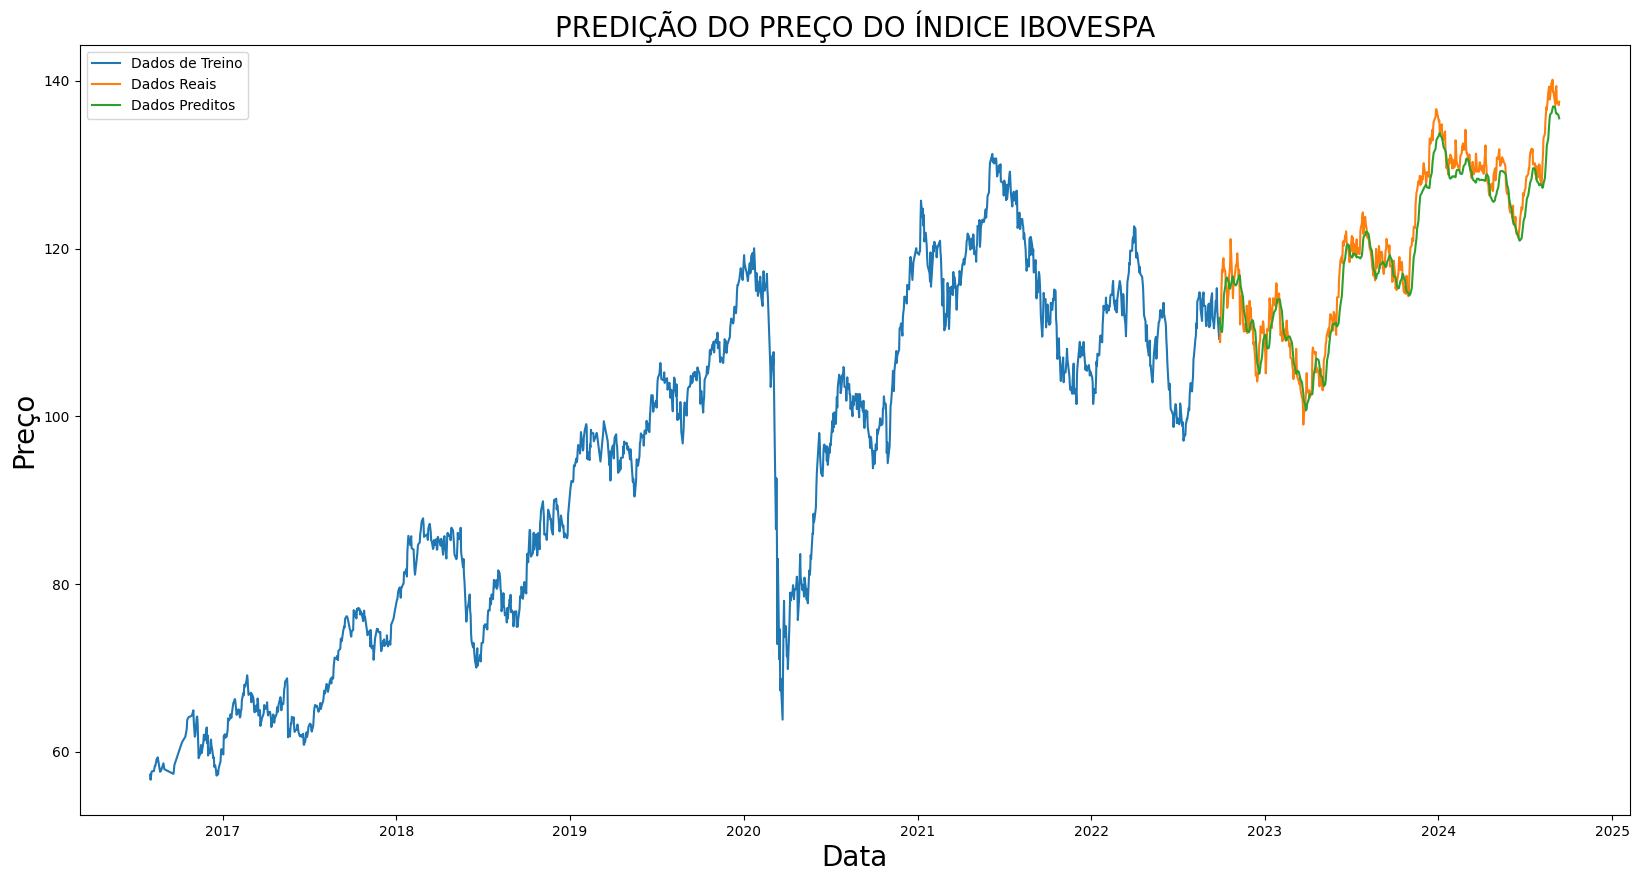

In [14]:
lstm_prediction(ibov_df)

Pode-se notar um valor bem baixo no Erro Médio Padrão (2.41) e um valor muito próximo de um para o Erro Quadrado (0.94), portanto, o modelo apresenta uma boa acurácia em sua predição. Além de visivelmente a linha correspondente aos valores preditos estar bem próxima dos dados reais.